In [1]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
from evaluation_metrics.segmentation_metrics import *
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
IMG_FOLDER = '/Users/lfidon/data/hubmap-kidney/validation_PAS/images_3000_3000_kidney'
CSV = '/Users/lfidon/data/hubmap-kidney/validation_PAS/val_kidney.csv'


In [2]:
data_p = 'data/coatTrainer.npz'
data_ens_p = 'data/coatTrainer_ens.npz'
pred_rle_p = 'data/rle_coatTrainer_ens.txt'
idx = '1e2425f28_53'
ori_img_p = os.path.join(IMG_FOLDER, '%s.tiff' % idx)


In [3]:
def load_image(tiff_path: str):
    img = io.imread(tiff_path)
    return img

def rle2mask(mask_rle, shape=(3000, 3000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def for_display(seg):
    out = np.copy(seg).astype(float)
    out[out == 0] = np.nan
    return out


In [43]:
img_ori = load_image(ori_img_p)
df = pd.read_csv(CSV)
rle = str(df[df['id'] == idx]['rle'].values[0])
seg = rle2mask(rle)
seg = cv2.resize(seg, (1500, 1500), interpolation=cv2.INTER_NEAREST)
with open(pred_rle_p, 'r') as f:
    rle_pred = f.read()
seg_pred = rle2mask(rle_pred)
seg_pred = cv2.resize(seg_pred, (1500, 1500), interpolation=cv2.INTER_NEAREST)
img = cv2.resize(img_ori, (1500, 1500))
data = np.load(data_p)
softmax_target = np.squeeze(data['softmax1'])[1, :, :]
pseudo_seg = np.squeeze(data['pgt'])
pseudo_seg[pseudo_seg == -1] = 2
softmax_tta = np.squeeze(data['softmax2'])[1, :, :]
data_ens = np.load(data_ens_p)
softmax_ens = np.squeeze(data_ens['softmax'])[1, :, :]


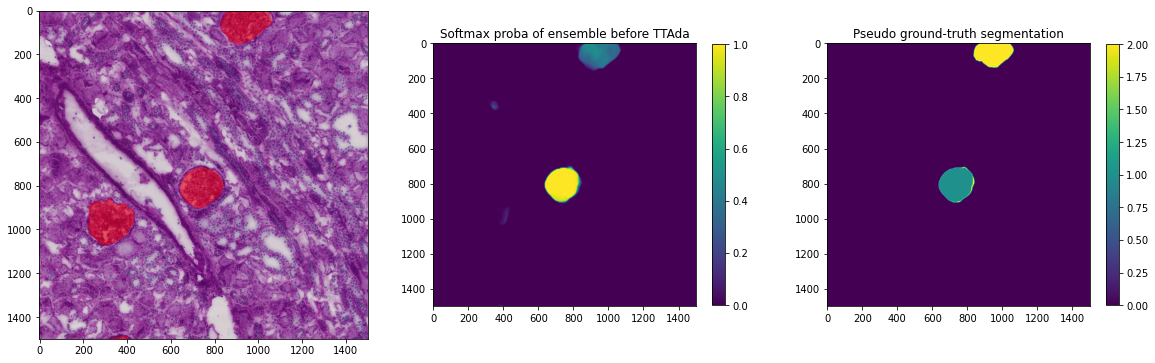

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(20, 60))
alpha = 0.5
ax[0].imshow(img)
ax[0].imshow(for_display(seg), alpha=alpha, cmap='hsv')
p1 = ax[1].imshow(softmax_target, vmin=0, vmax=1)
ax[1].set_title('Softmax proba of ensemble before TTAda')
fig.colorbar(p1, ax=ax[1], location='right', shrink=0.08)
p2 = ax[2].imshow(pseudo_seg, vmin=0, vmax=2)
ax[2].set_title('Pseudo ground-truth segmentation')
fig.colorbar(p2, ax=ax[2], shrink=0.08)


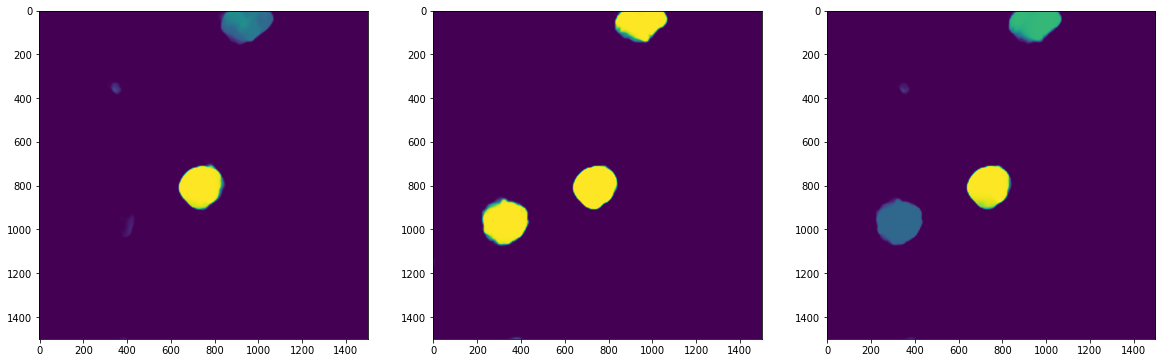

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(20, 60))
ax[0].imshow(softmax_target, vmin=0, vmax=1)
ax[1].imshow(softmax_tta, vmin=0, vmax=1)
ax[2].imshow(softmax_ens, vmin=0, vmax=1)


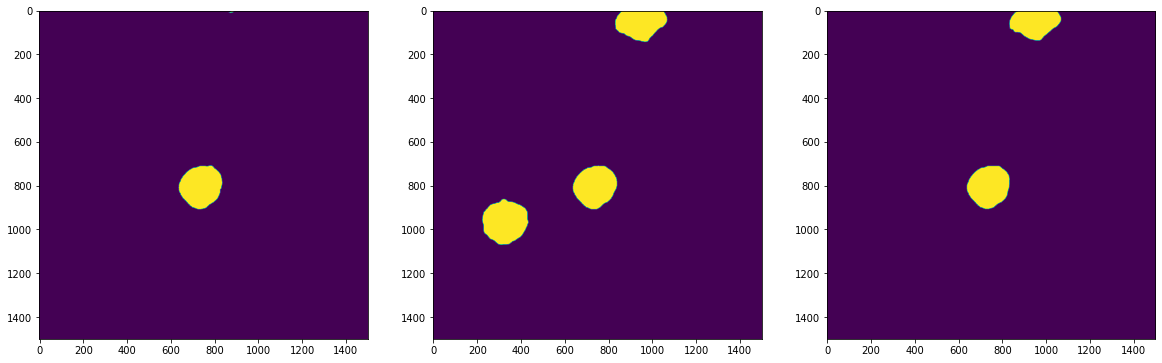

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(20, 60))
ax[0].imshow(softmax_target > 0.5)
ax[1].imshow(softmax_tta > 0.5)
ax[2].imshow(softmax_ens > 0.5)


In [28]:
dice_score(seg, (softmax_target > 0.5).astype(np.uint8), fg_class=1)

0.7108820808060039

In [29]:
dice_score(seg, (softmax_tta > 0.5).astype(np.uint8), fg_class=1)

0.9328954593678195

In [30]:
dice_score(seg, (softmax_ens > 0.5).astype(np.uint8), fg_class=1)

0.9291813804173354

Seg from predicted rle


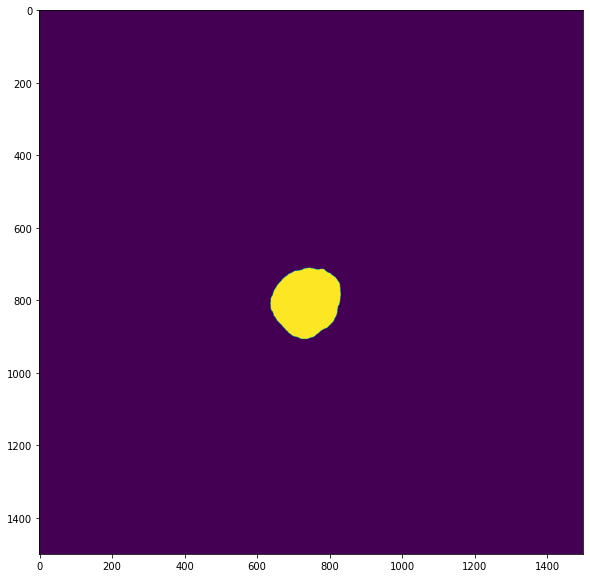

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(seg_pred, vmin=0, vmax=1)
print('Seg from predicted rle')